In this notebook, we will be using YOLOv8 to detect ships in images. Here's an outline of the processes we will go through:

Import the necessary libraries: We will import the required libraries such as Pandas, matplotlib, OpenCV, and other dependencies for training and inference with YOLOv8.

Load and check the file paths: We will ensure that the file paths for the image dataset, metadata JSON file are correctly specified.

Create a DataFrame from the JSON file: We will iterate over the JSON file to extract image metadata, including bounding boxes and categories. This information will be used to create a DataFrame, which will make data manipulation easier.

Divide the data into train and validation sets: We will split the DataFrame into training and validation sets to prepare for model training. This ensures that the model learns from a diverse range of examples and can generalize well.

Check the DataFrame and visualize images with bounding boxes: We will verify the correctness of the DataFrame by inspecting a few rows and visualizing the corresponding images with their bounding boxes overlaid. This step helps to ensure that the data is properly structured and the annotations align with the images.

Structure the data files: We will organize the image and label files into the required folder structure for YOLOv8 training. This typically involves creating separate directories for train and validation sets, and within each directory, storing the images and label files in a specific format.

Train the model: With the data properly organized, we will train the YOLOv8 model using the training set. This step involves feeding the prepared data to the model, optimizing the model's parameters through backpropagation, and iteratively updating the weights to improve performance.

Use the test set for predictions: Once the model is trained, we will utilize the test set to evaluate the model's performance and make predictions on unseen ship images. This allows us to assess the model's accuracy and assess how well it generalizes to new ship images.

Imports

In [1]:
import os
import json
import glob
from tqdm import tqdm
from pathlib import Path
import shutil

import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import pandas as pd

In [2]:
train_dir = 'train'
test_dir = 'test'

In [3]:
images = glob.glob(train_dir+'/*')
images = sorted(images)

In [5]:
train_files = os.listdir(train_dir)
print("Train Files:",len(train_files))

test_files = os.listdir(test_dir)
print("Test Files:",len(test_files))

Train Files: 257
Test Files: 386


The below code reads a JSON file and outputs a dataframe in desired format-

In [7]:
def make_df(image_dir):
    with open(f'{image_dir}/metadata.jsonl', 'r') as json_file:
        json_list = list(json_file)

    # Initialize empty lists to store data
    file_name = []
    bboxes = []
    categories = []

    # Iterate over each JSON string in the JSON list
    for json_str in json_list:
        result = json.loads(json_str)

        # Append corresponding data to the lists
        file_name.append(result['file_name'])
        bboxes.append(result['objects']['bbox'])
        categories.append(result['objects']['categories'])

    # Create a DataFrame with three columns using the lists
    df = pd.DataFrame([file_name, bboxes, categories]).T
    df.columns = ['image_id', 'bbox', 'category']
    df = df.explode(column=['bbox', 'category']).reset_index(drop=True)

    # Add image width and height columns to the dataframe
    img_height = []
    img_width = []
    image_id = []
    all_files = df.image_id.unique().tolist()
    for f in all_files:
        img = cv2.imread(f'{image_dir}/{f}')
        img_height.append(img.shape[0])
        img_width.append(img.shape[1])
        image_id.append(f)

    # Create a temporary DataFrame with image_id, height, and width columns
    tmp = pd.DataFrame([image_id, img_height, img_width]).T
    tmp.columns = ['image_id', 'height', 'width']
    df = df.merge(tmp, on='image_id', how='left')
    del tmp
    
    df[['image_id', 'height', 'width', 'bbox']]

    return df

In [8]:
df_train = make_df(train_dir)
#test_df = make_df(test_dir)

In [9]:
image_ids = df_train['image_id'].unique()
valid_ids = image_ids[200:]
train_ids = image_ids[:200]

val_df = df_train[df_train['image_id'].isin(valid_ids)]
train_df = df_train[df_train['image_id'].isin(train_ids)]

In [10]:
train_df

,image_id,bbox,category,height,width
0,0.png,"[6690, 3599, 7164, 3850]",0,4912,7360
1,0.png,"[6772, 3386, 7039, 3546]",0,4912,7360
2,0.png,"[6705, 3291, 7060, 3485]",0,4912,7360
3,0.png,"[6230, 3442, 6597, 3647]",0,4912,7360
4,0.png,"[5501, 790, 5552, 868]",0,4912,7360
...,...,...,...,...,...
18953,199.png,"[1546, 1792, 1645, 1898]",0,4348,4467
18954,199.png,"[1731, 1666, 1762, 1739]",0,4348,4467
18955,199.png,"[1705, 1628, 1733, 1730]",0,4348,4467
18956,199.png,"[1503, 1846, 1605, 1948]",0,4348,4467


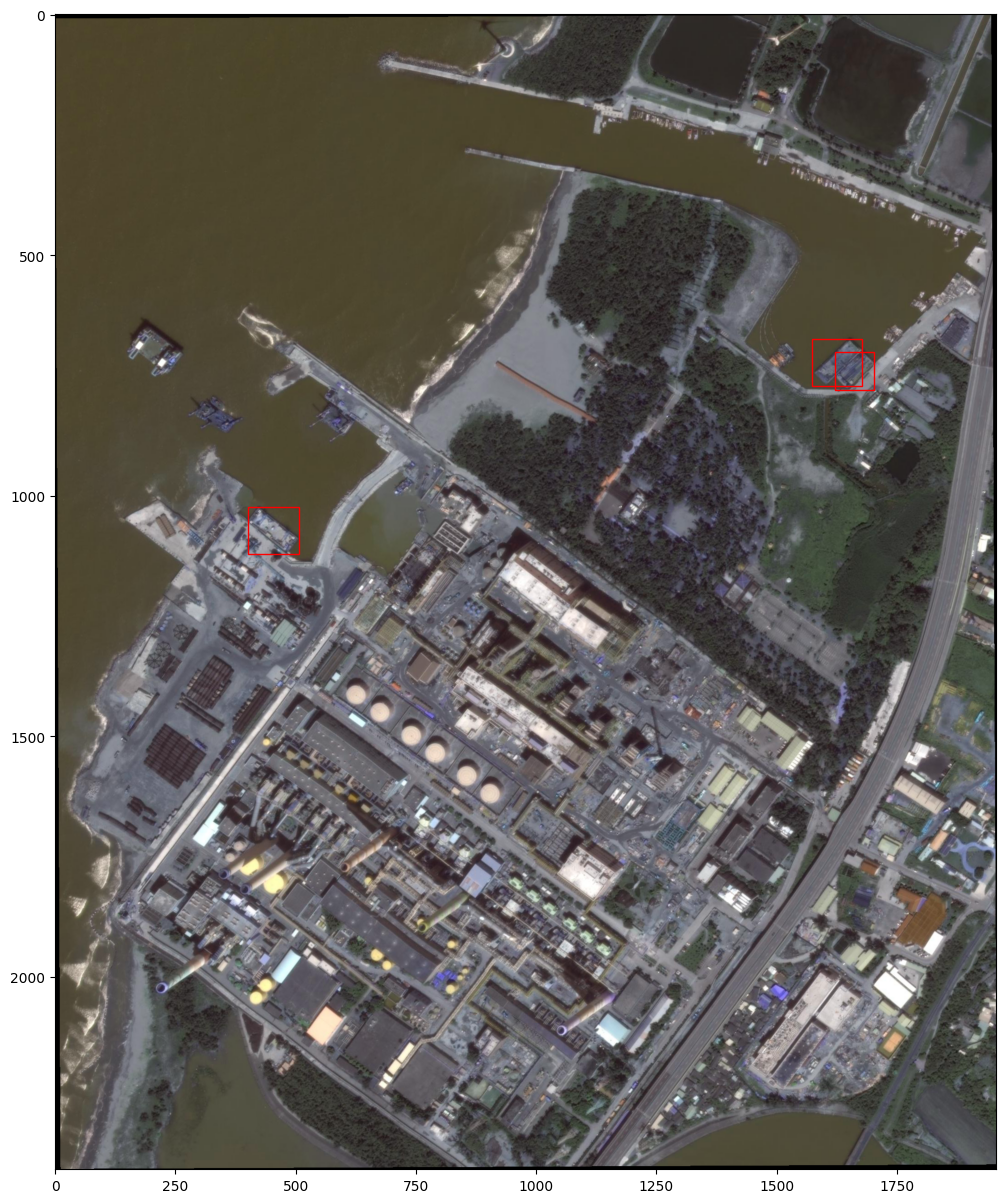

In [11]:
def display_img(f):
    img_path = os.path.join(f'{train_dir}/{f}')
    img = cv2.imread(img_path)

    fig, ax = plt.subplots(figsize=(15, 15))
    ax.imshow(img);
    bboxes = train_df[train_df.image_id==f]['bbox'].tolist()

    for b in bboxes:    
#         print(b)
        rect = patches.Rectangle((b[0],b[1]),b[2]-b[0],b[3]-b[1], linewidth=1, edgecolor='r', facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

display_img('121.png')

Now that we have a dataframe ready, which makes data manipulation easy, we need to prepare the data in a format that YOLO expects. In YOLO, the bounding boxes need to be converted to a specific format to avoid errors. The YOLO format represents bounding boxes using the normalized values of the center coordinates (xcenter, ycenter), width, and height.

To ensure compatibility with YOLO, we will convert the bounding boxes to this format. This involves calculating the center coordinates, width, and height of each bounding box and normalizing them. Once the bounding boxes are converted to the YOLO format, we can proceed to structure data folders the way YOLO expexts them.

In [12]:
# make output_dir
dest_dir = "yolo_ship_data"
!mkdir {dest_dir}

_ = Path(f"{dest_dir}/dataset.yaml").write_text(f"""path: {dest_dir}
train: D:\\CODE\\ship-detection\\yolo_ship_data\\images\\train
val: D:\\CODE\\ship-detection\\yolo_ship_data\\images\\val


nc: 1
names: ['ship']
""")

A subdirectory or file yolo_ship_data already exists.


In [ ]:
def create_txt_file(path: Path, bboxes, width, height):
    """Creates a .txt file with annotation strings for the given bounding boxes"""
    
    anno_str = []
    for bbox in bboxes:
        xmin, ymin, xmax, ymax = bbox[0], bbox[1], bbox[2], bbox[3]

        # Calculate the center coordinates
        w = xmax - xmin
        h = ymax - ymin
        xc = xmin + w / 2
        yc = ymin + h / 2

        # Normalize the coordinates
        xc /= width
        yc /= height
        w /= width
        h /= height
        anno_str.append(f"0 {xc} {yc} {w} {h}")
    path.write_text("\n".join(anno_str))

In [13]:
path_list = []

# Iterate over the modes 'train' and 'val'
for mode in ["train", "val"]:
    image_folder = Path(dest_dir) / "images" / f"{mode}"
    image_folder.mkdir(parents=True, exist_ok=True)

    label_folder = Path(dest_dir) / "labels" / f"{mode}"
    label_folder.mkdir(parents=True, exist_ok=True)

    # Get the dataframe based on the current mode
    df = locals().get(f"{mode}_df")
    grouped = df.groupby('image_id')

    # Iterate over each image_id and its corresponding group_df
    for image_id, group_df in tqdm(grouped, total=len(grouped)):
        # Extract file_name, width, and height from the first row of group_df
        file_name = f"{image_id.split('.')[0]}"
        width, height = group_df.iloc[0].width, group_df.iloc[0].height

        # Extract the bounding boxes from each row in the group_df
        bboxes = [row.bbox for _, row in group_df.iterrows()]

        # Define paths for the image and label files
        img_path = image_folder / f"{file_name}.png"
        label_path = label_folder / f"{file_name}.txt"
        shutil.copy(f"{train_dir}/{image_id}", img_path)
        create_txt_file(label_path, bboxes, width, height)
        path_list.append((str(img_path), str(label_path)))

100%|████████████████████████████████████████████████████████████████████████████████| 385/385 [01:04<00:00,  5.98it/s]


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
import ultralytics
from ultralytics import YOLO

# Load a model
model = YOLO("yolov8n.pt")
model.to(device)

In [18]:
# Training.

results = model.train(
   data='D:\CODE\ship-detection\yolo_ship_data\dataset.yaml',
   imgsz=1024,
   epochs=10,
   batch=8,
    workers=2,
    device='cpu',
   name='yolov8n_v1_10epoch'
)


New https://pypi.org/project/ultralytics/8.0.75 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.66  Python-3.11.0 torch-2.0.0+cu118 CPU
yolo\engine\trainer: task=detect, mode=train, model=yolov8n.yaml, data=D:\CODE\ship-detection\yolo_ship_data\dataset.yaml, epochs=10, patience=50, batch=8, imgsz=1024, save=True, save_period=-1, cache=False, device=cpu, workers=2, project=None, name=yolov8n_v1_10epoch, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=

       7/10         0G      4.389      3.298      2.253        230       1024: 100%|██████████| 25/25 [07:03<00:00, 16.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [01:24<0
                   all         56       2784      0.147       0.06     0.0196    0.00404

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       8/10         0G      4.252      3.264      2.354         58       1024: 100%|██████████| 25/25 [06:50<00:00, 16.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [01:23<0
                   all         56       2784      0.168     0.0654      0.031    0.00562

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       9/10         0G      4.355      3.882      2.294         49       1024: 100%|██████████| 25/25 [06:50<00:00, 16.
                 Class     Images  Instances      Box(P         

The code from here onwards is taken from - https://github.com/Nischaydnk/hf-shipdetection_baseline/blob/main/yolov8_train_inf.ipynb

In [16]:
result_paths = glob.glob('runs\detect\yolov8n_v1_10epoch/*jpg') +  glob.glob('runs\detect\yolov8n_v1_10epoch/*png')

In [17]:
result_paths

['runs\\detect\\yolov8n_v1_10epoch\\labels.jpg',
 'runs\\detect\\yolov8n_v1_10epoch\\labels_correlogram.jpg',
 'runs\\detect\\yolov8n_v1_10epoch\\train_batch0.jpg',
 'runs\\detect\\yolov8n_v1_10epoch\\train_batch1.jpg',
 'runs\\detect\\yolov8n_v1_10epoch\\train_batch2.jpg',
 'runs\\detect\\yolov8n_v1_10epoch\\val_batch0_labels.jpg',
 'runs\\detect\\yolov8n_v1_10epoch\\val_batch0_pred.jpg',
 'runs\\detect\\yolov8n_v1_10epoch\\val_batch1_labels.jpg',
 'runs\\detect\\yolov8n_v1_10epoch\\val_batch1_pred.jpg',
 'runs\\detect\\yolov8n_v1_10epoch\\val_batch2_labels.jpg',
 'runs\\detect\\yolov8n_v1_10epoch\\val_batch2_pred.jpg',
 'runs\\detect\\yolov8n_v1_10epoch\\confusion_matrix.png',
 'runs\\detect\\yolov8n_v1_10epoch\\F1_curve.png',
 'runs\\detect\\yolov8n_v1_10epoch\\PR_curve.png',
 'runs\\detect\\yolov8n_v1_10epoch\\P_curve.png',
 'runs\\detect\\yolov8n_v1_10epoch\\results.png',
 'runs\\detect\\yolov8n_v1_10epoch\\R_curve.png']

In [18]:
result_paths = result_paths[-7:]

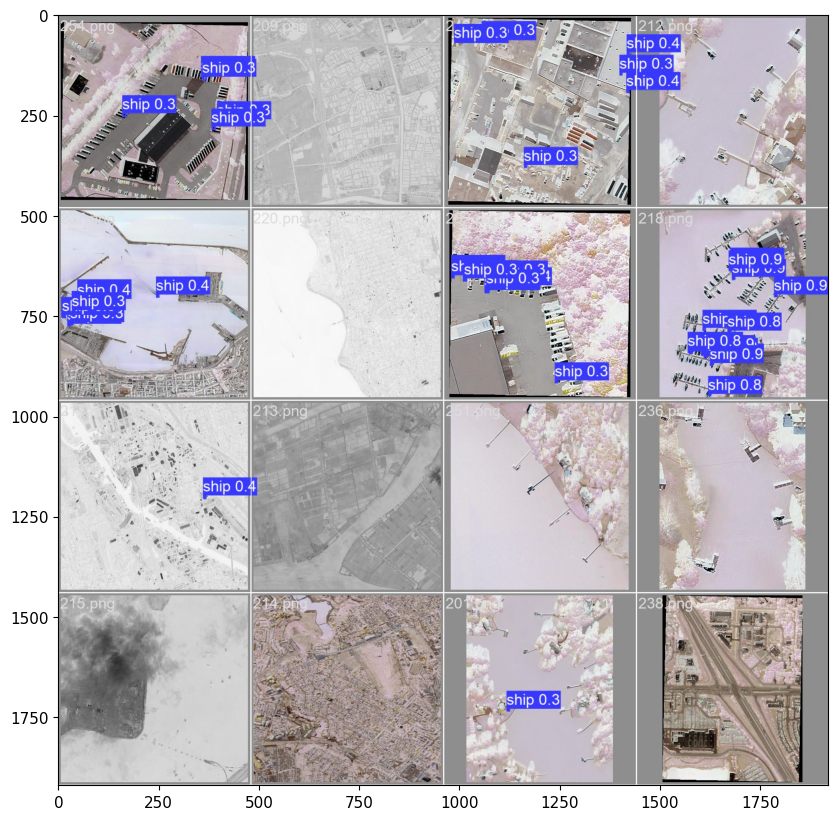

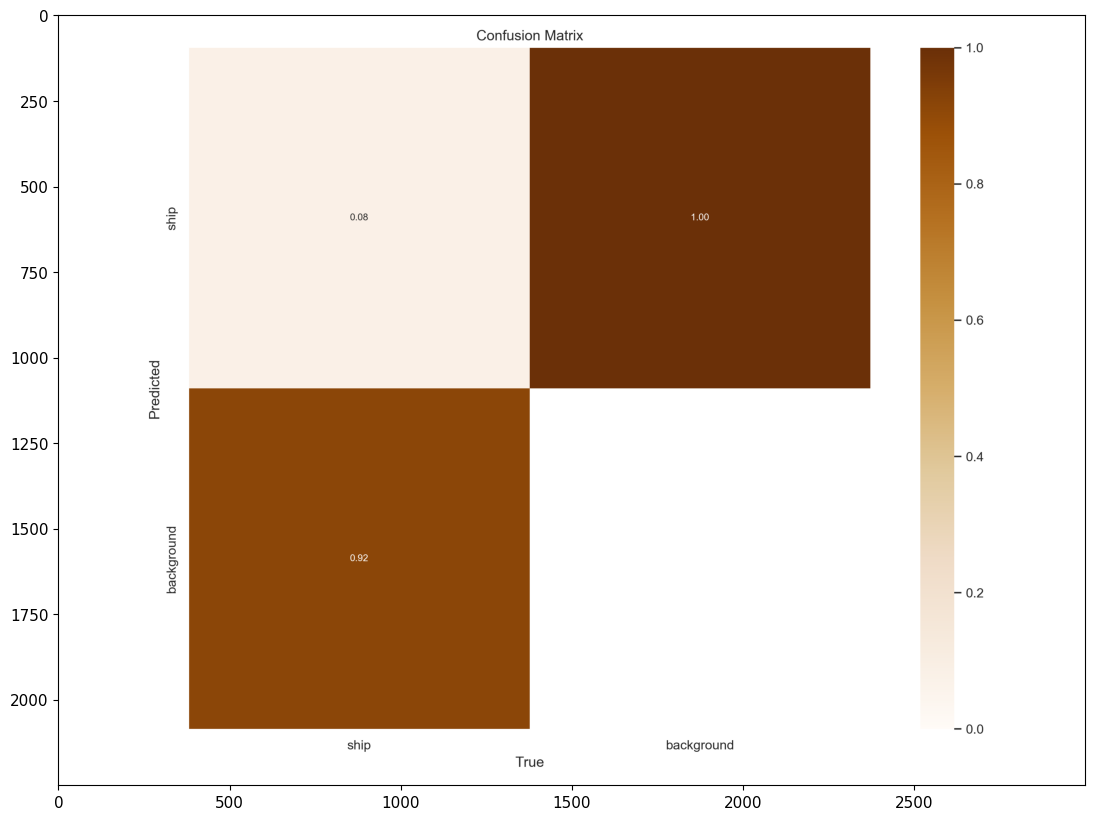

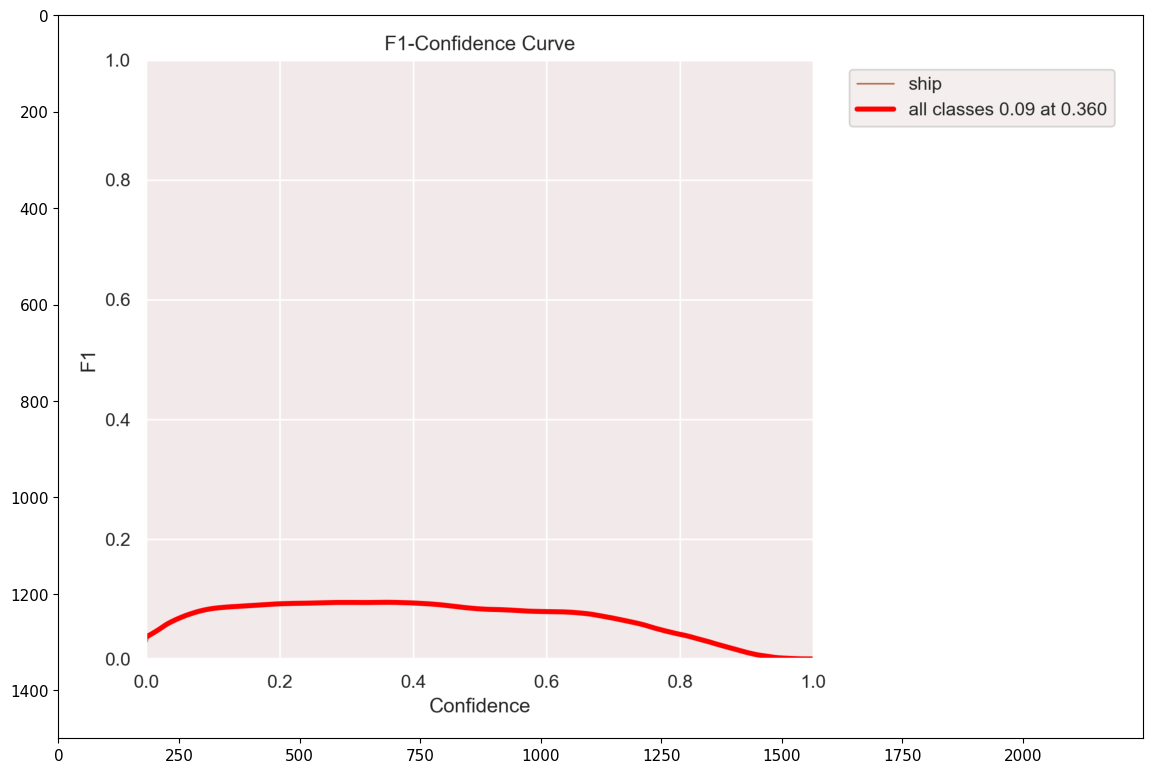

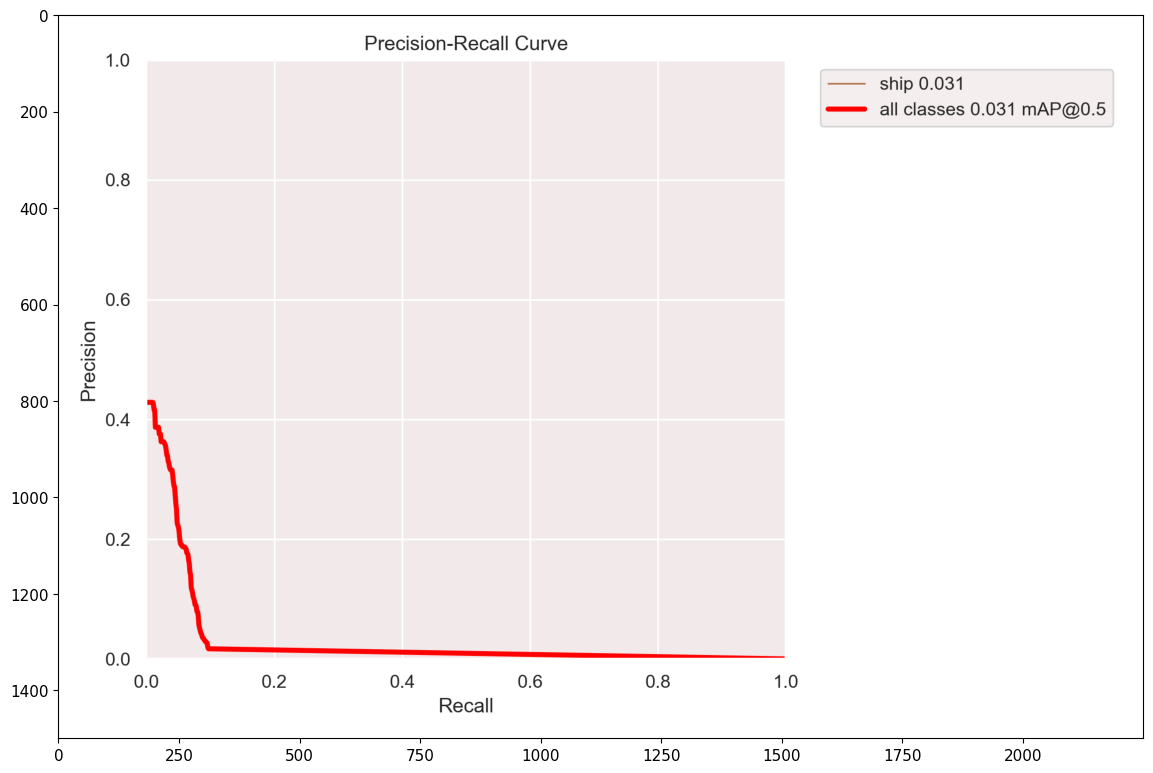

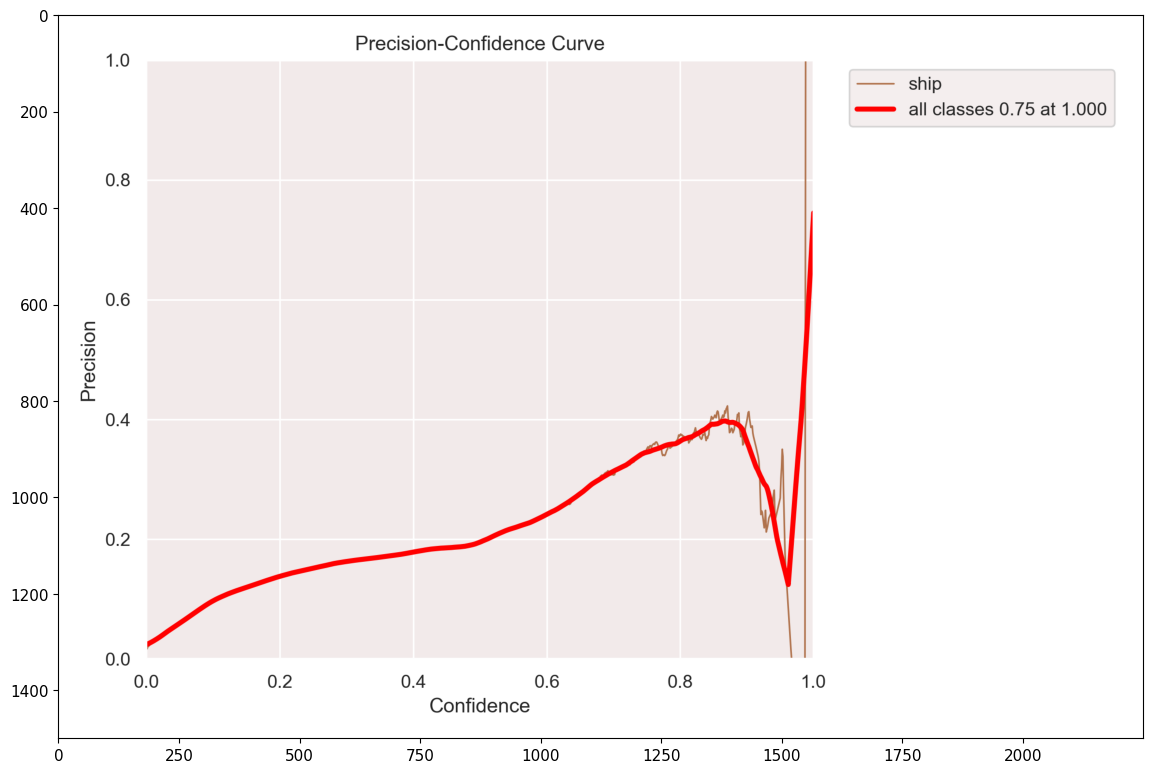

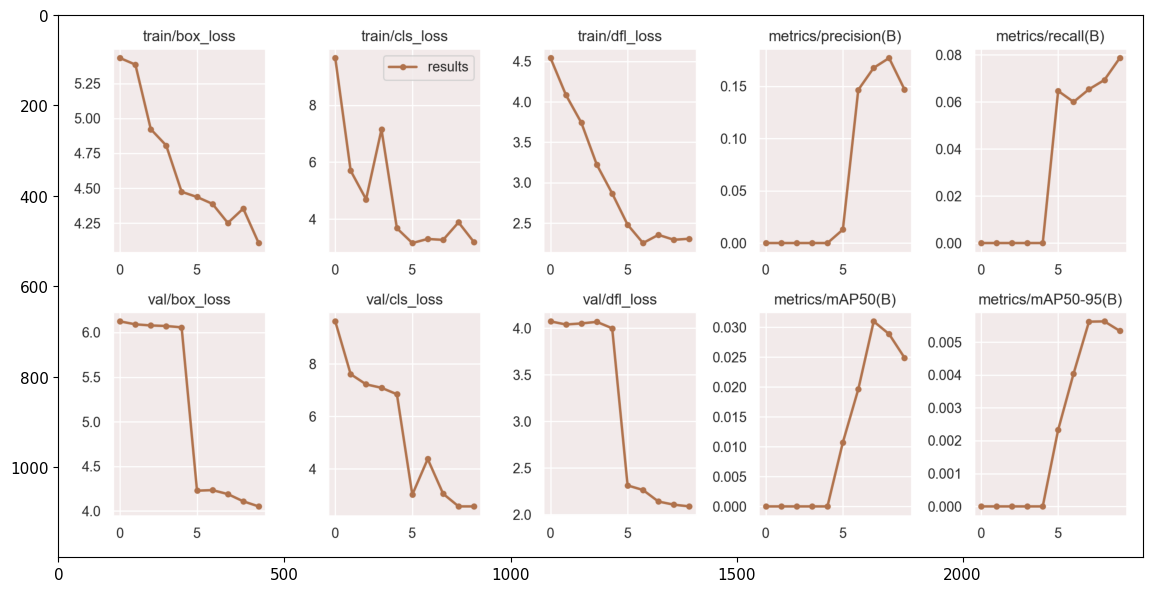

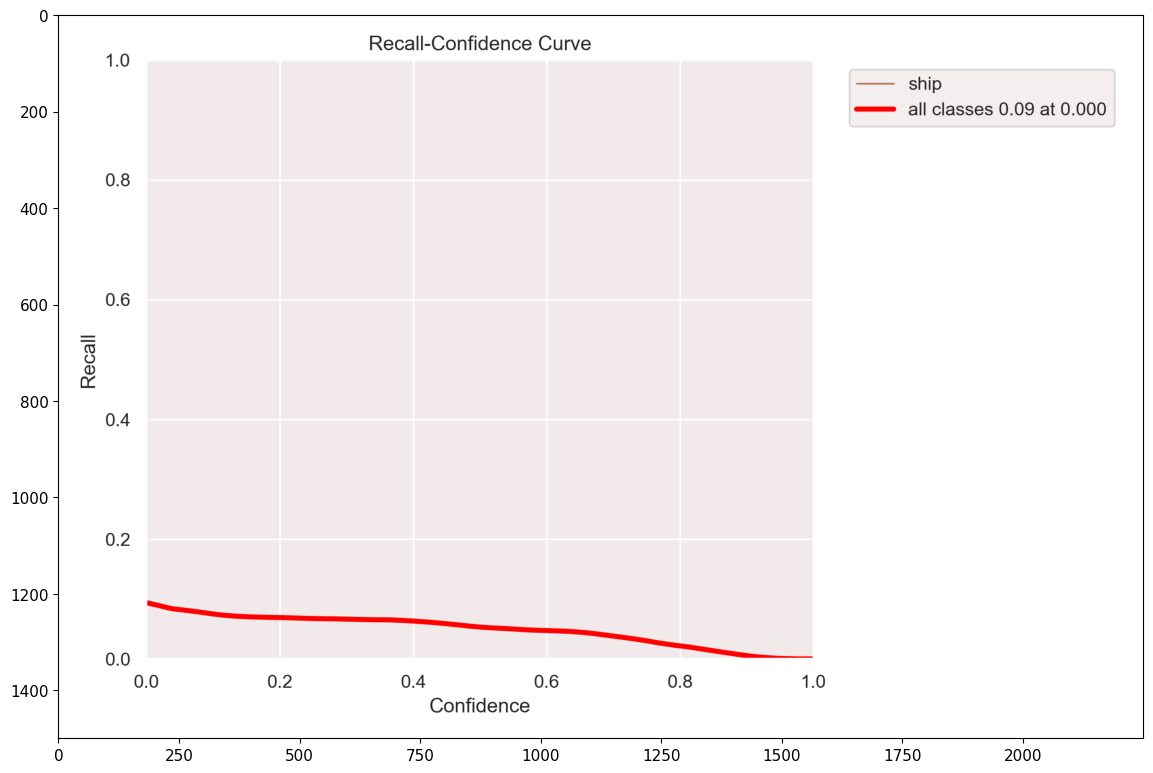

In [19]:
%matplotlib inline

for path in result_paths:
    image = cv2.imread(path)
    plt.figure(figsize=(14,10))
    plt.imshow(image)
    plt.show()

In [14]:
model_best = YOLO("runs\\detect\\best.pt")

In [15]:
preds = model_best.predict(conf = 0.1, source = "D:\\CODE\\ship-detection\\test")


image 1/385 D:\CODE\ship-detection\test\0.png: 480x736 174 ships, 78.9ms
image 2/385 D:\CODE\ship-detection\test\1.png: 576x736 3 ships, 104.0ms
image 3/385 D:\CODE\ship-detection\test\10.png: 736x736 104 ships, 0.0ms
image 4/385 D:\CODE\ship-detection\test\100.png: 736x608 32 ships, 125.7ms
image 5/385 D:\CODE\ship-detection\test\101.png: 736x640 14 ships, 101.5ms
image 6/385 D:\CODE\ship-detection\test\102.png: 576x736 222 ships, 0.0ms
image 7/385 D:\CODE\ship-detection\test\103.png: 736x736 9 ships, 0.0ms
image 8/385 D:\CODE\ship-detection\test\104.png: 736x736 166 ships, 0.0ms
image 9/385 D:\CODE\ship-detection\test\105.png: 704x736 14 ships, 94.9ms
image 10/385 D:\CODE\ship-detection\test\106.png: 736x736 124 ships, 0.0ms
image 11/385 D:\CODE\ship-detection\test\107.png: 224x736 16 ships, 126.0ms
image 12/385 D:\CODE\ship-detection\test\108.png: 736x384 183 ships, 126.3ms
image 13/385 D:\CODE\ship-detection\test\109.png: 736x672 41 ships, 125.7ms
image 14/385 D:\CODE\ship-detecti

image 110/385 D:\CODE\ship-detection\test\197.png: 736x320 8 ships, 79.1ms
image 111/385 D:\CODE\ship-detection\test\198.png: 64x736 2 ships, 78.4ms
image 112/385 D:\CODE\ship-detection\test\199.png: 608x736 29 ships, 31.4ms
image 113/385 D:\CODE\ship-detection\test\2.png: 224x736 116 ships, 11.5ms
image 114/385 D:\CODE\ship-detection\test\20.png: 736x736 19 ships, 39.9ms
image 115/385 D:\CODE\ship-detection\test\200.png: 736x608 48 ships, 31.2ms
image 116/385 D:\CODE\ship-detection\test\201.png: 416x736 300 ships, 31.3ms
image 117/385 D:\CODE\ship-detection\test\202.png: 608x736 18 ships, 28.1ms
image 118/385 D:\CODE\ship-detection\test\203.png: 736x480 170 ships, 125.6ms
image 119/385 D:\CODE\ship-detection\test\204.png: 512x736 143 ships, 31.3ms
image 120/385 D:\CODE\ship-detection\test\205.png: 512x736 135 ships, 21.7ms
image 121/385 D:\CODE\ship-detection\test\206.png: 640x736 249 ships, 28.1ms
image 122/385 D:\CODE\ship-detection\test\207.png: 512x736 120 ships, 46.8ms
image 123/

image 218/385 D:\CODE\ship-detection\test\294.png: 352x736 5 ships, 47.2ms
image 219/385 D:\CODE\ship-detection\test\295.png: 416x736 17 ships, 31.6ms
image 220/385 D:\CODE\ship-detection\test\296.png: 736x448 23 ships, 57.4ms
image 221/385 D:\CODE\ship-detection\test\297.png: 736x736 10 ships, 94.1ms
image 222/385 D:\CODE\ship-detection\test\298.png: 544x736 20 ships, 53.9ms
image 223/385 D:\CODE\ship-detection\test\299.png: 576x736 89 ships, 47.3ms
image 224/385 D:\CODE\ship-detection\test\3.png: 736x544 300 ships, 31.2ms
image 225/385 D:\CODE\ship-detection\test\30.png: 576x736 94 ships, 15.6ms
image 226/385 D:\CODE\ship-detection\test\300.png: 736x480 300 ships, 31.3ms
image 227/385 D:\CODE\ship-detection\test\301.png: 736x736 (no detections), 31.6ms
image 228/385 D:\CODE\ship-detection\test\302.png: 736x736 21 ships, 31.6ms
image 229/385 D:\CODE\ship-detection\test\303.png: 736x736 4 ships, 43.4ms
image 230/385 D:\CODE\ship-detection\test\304.png: 736x608 300 ships, 31.4ms
image 2

image 326/385 D:\CODE\ship-detection\test\45.png: 672x736 14 ships, 31.2ms
image 327/385 D:\CODE\ship-detection\test\46.png: 480x736 24 ships, 15.5ms
image 328/385 D:\CODE\ship-detection\test\47.png: 672x736 6 ships, 31.6ms
image 329/385 D:\CODE\ship-detection\test\48.png: 736x512 22 ships, 31.7ms
image 330/385 D:\CODE\ship-detection\test\49.png: 736x320 12 ships, 0.0ms
image 331/385 D:\CODE\ship-detection\test\5.png: 736x544 20 ships, 16.0ms
image 332/385 D:\CODE\ship-detection\test\50.png: 736x576 35 ships, 31.2ms
image 333/385 D:\CODE\ship-detection\test\51.png: 512x736 13 ships, 15.7ms
image 334/385 D:\CODE\ship-detection\test\52.png: 320x736 37 ships, 15.6ms
image 335/385 D:\CODE\ship-detection\test\53.png: 256x736 46 ships, 15.5ms
image 336/385 D:\CODE\ship-detection\test\54.png: 576x736 8 ships, 62.9ms
image 337/385 D:\CODE\ship-detection\test\55.png: 736x608 255 ships, 47.3ms
image 338/385 D:\CODE\ship-detection\test\56.png: 512x736 235 ships, 46.9ms
image 339/385 D:\CODE\ship-

In [16]:
test_images_sort = [f'test/{i}.png' for i in range(386)]

In [17]:
test_preds = pd.DataFrame(columns=range(6))
for i in range(len(preds)):
    arri = pd.DataFrame(preds[i].boxes.boxes.cpu()).astype(float)
    path = test_images_sort[i]
    file = path.split('/')[-1]
    arri = arri.assign(file=file)
    arri = arri.assign(i=i)
    test_preds = pd.concat([test_preds,arri],axis=0)
test_preds.columns = ['xmin','ymin','xmax','ymax','confidence','class','id','i']
display(test_preds)

,xmin,ymin,xmax,ymax,confidence,class,id,i
0,772.746582,626.292786,792.210449,651.325317,0.738334,0.0,0.png,0.0
1,833.757996,598.020508,853.540833,620.336853,0.736521,0.0,0.png,0.0
2,445.917511,852.501831,460.509064,879.145264,0.662609,0.0,0.png,0.0
3,793.425476,612.568176,815.701294,640.523865,0.654792,0.0,0.png,0.0
4,386.351044,434.746582,414.590607,447.315918,0.644375,0.0,0.png,0.0
...,...,...,...,...,...,...,...,...
242,2733.374512,6255.724121,2834.325684,6317.524902,0.104662,0.0,384.png,384.0
243,3146.328125,4831.462402,3212.604492,4926.886719,0.103287,0.0,384.png,384.0
244,2315.695801,5771.167969,2380.183350,5829.547852,0.102243,0.0,384.png,384.0
245,2115.452393,5442.129395,2185.592041,5500.713867,0.101909,0.0,384.png,384.0


In [18]:
test_preds = test_preds[["id","xmin","ymin","xmax","ymax","confidence"]].reset_index(drop=True)

In [19]:
sample_sub = pd.DataFrame([i.split('/')[-1] for i in test_files],columns=["id"]).reset_index(drop=True)
sample_sub["label"] = "0 0 0 10 10"

In [20]:
import tqdm 
tqdm.tqdm.pandas()

# Convert detections to string format

for i in tqdm.tqdm(range(len(sample_sub))):
    detections = []
    idd = sample_sub.loc[i,'id']
    df = test_preds[test_preds['id']==idd]
#     print(len(df))
    for i, row in df.iterrows():
        detection_str = f"{row['confidence']} {int(row['xmin'])} {int(row['ymin'])} {int(row['xmax'])} {int(row['ymax'])}"
        detections.append(detection_str)
    detections_str = ', '.join(detections)
    idx = list(sample_sub[sample_sub['id']==idd].index)
    if len(df)>0:
        sample_sub.loc[idx,"label"] = detections_str
#     break

100%|███████████████████████████████████████████████████████████████████████████████| 386/386 [00:03<00:00, 125.88it/s]


In [21]:
sample_sub.to_csv('submission.csv',index=False)

In [22]:
test_preds['path'] = 'test/' + test_preds['id']
test_preds['class'] = 'ship'

In [23]:
test_preds.head(10)

,id,xmin,ymin,xmax,ymax,confidence,path,class
0,0.png,772.746582,626.292786,792.210449,651.325317,0.738334,test/0.png,ship
1,0.png,833.757996,598.020508,853.540833,620.336853,0.736521,test/0.png,ship
2,0.png,445.917511,852.501831,460.509064,879.145264,0.662609,test/0.png,ship
3,0.png,793.425476,612.568176,815.701294,640.523865,0.654792,test/0.png,ship
4,0.png,386.351044,434.746582,414.590607,447.315918,0.644375,test/0.png,ship
5,0.png,756.996704,636.364502,775.281982,661.274963,0.639594,test/0.png,ship
6,0.png,772.993591,542.847168,795.114563,567.984863,0.634455,test/0.png,ship
7,0.png,387.338318,440.131134,412.606873,452.684509,0.581687,test/0.png,ship
8,0.png,639.860352,440.195618,658.432312,468.199127,0.564677,test/0.png,ship
9,0.png,831.694641,665.730591,855.548767,688.573425,0.546320,test/0.png,ship


In [ ]:
df = test_preds

# Loop through the rows of the dataframe and draw bounding boxes
for i, row in df.iterrows():
    # Load the image
    img = cv2.imread(row['path'])
    # Extract the coordinates of the bounding box
    xmin = int(row['xmin'])
    ymin = int(row['ymin'])
    xmax = int(row['xmax'])
    ymax = int(row['ymax'])
    # Draw the bounding box on the image
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
    # Convert BGR to RGB for display in Matplotlib
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Display the image with the bounding box
    plt.imshow(img)
    plt.annotate(row['class'], xy=(xmin, ymin), color='red')
    plt.show()

C:\Users\vaibh\AppData\Local\Temp\ipykernel_21300\1827517175.py:19: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


KeyboardInterrupt: 

For this problem set we have limited number of training images. To overcome the data scarcity issue, we will apply data augmentation techniques. Data augmentation helps increase the diversity and quantity of training samples, which can improve the model's performance and generalization ability.

Additionally, since training a YOLO model from scratch can be computationally intensive, an alternative approach is to use a pre-trained YOLO model as a starting point. By fine-tuning the pre-trained model on our specific ship detection task, we can leverage the learned features and accelerate the training process. Depending on the available computational resources, training a YOLO model from scratch may require significant computing power due to the complexity and size of the model. In such cases, using pre-trained models or exploring transfer learning techniques can be advantageous.

However, it's important to note that fine-tuning hyperparameters is crucial to achieving optimal performance. Hyperparameters such as learning rate, batch size, number of training iterations, and weight decay need to be carefully tuned to ensure effective training and prevent overfitting or underfitting